In [ ]:
!pip install -q -U datasets torch imbalanced-learn transformers

In [ ]:
from datasets import load_dataset

dataset = load_dataset("takala/financial_phrasebank", "sentences_50agree", trust_remote_code = True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})

## Preprocess using Pretrained tokenizer


In [ ]:
from transformers import AutoTokenizer

# Replace 'bert-base-uncased' with your specific model's name
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples['sentence'],   # Adjust key based on your dataset
        padding="max_length",  # Pad to max_length (helps batching)
        truncation=True,       # Truncate sequences longer than max_length
        max_length=128         # Set a suitable max_length

    )

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [ ]:
split_dataset = tokenized_dataset['train'].train_test_split(test_size=0.2)

train_data = split_dataset['train']
test_data = split_dataset['test']



# Set the format for PyTorch tensors
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
import torch
import random

# First, separate examples by label
label_0_indices = [i for i, label in enumerate(train_data['label']) if label == 0]
label_1_indices = [i for i, label in enumerate(train_data['label']) if label == 1]
label_2_indices = [i for i, label in enumerate(train_data['label']) if label == 2]

# Find the size of the smallest class
min_size = min(len(label_0_indices), len(label_1_indices), len(label_2_indices))

# Randomly sample from each class to get equal numbers
random.seed(42)  # for reproducibility
balanced_0_indices = random.sample(label_0_indices, min_size)
balanced_1_indices = random.sample(label_1_indices, min_size)
balanced_2_indices = random.sample(label_2_indices, min_size)

# Combine all indices and create new balanced dataset
all_balanced_indices = balanced_0_indices + balanced_1_indices + balanced_2_indices
balanced_train_data = train_data.select(all_balanced_indices)

# Verify the new distribution
unique_labels, counts = torch.unique(balanced_train_data['label'], return_counts=True)
print("\nNew balanced distribution:")
for label, count in zip(unique_labels, counts):
    sentiment = "Negative" if label == 0 else "Neutral" if label == 1 else "Positive"
    print(f"{sentiment} (Label {label}): {count.item()} reviews")

# Print total sizes
print(f"\nOriginal dataset size: {len(train_data)}")
print(f"Balanced dataset size: {len(balanced_train_data)}")

train_data = balanced_train_data



New balanced distribution:
Negative (Label 0): 488 reviews
Neutral (Label 1): 488 reviews
Positive (Label 2): 488 reviews

Original dataset size: 3876
Balanced dataset size: 1464


In [ ]:
# Get all indices in random order
indices = torch.randperm(len(train_data)).tolist()

# Shuffle the dataset using these indices
train_data = train_data.select(indices)

# Verify it's shuffled by printing first 10 labels
print("First 10 labels after shuffling:", train_data['label'][:10].tolist())


First 10 labels after shuffling: [2, 2, 0, 0, 2, 2, 0, 2, 2, 1]


## Model Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import classification_report
import random

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_size=128, num_layers=2, num_classes=3, dropout_rate=0.3):
        super(LSTMModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)

        # Dropout and normalization
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)

    def attention_net(self, lstm_output, attention_mask):
        # Calculate attention scores
        attention_weights = self.attention(lstm_output)
        attention_weights = attention_weights.squeeze(-1)

        # Apply attention mask
        attention_weights = attention_weights.masked_fill(~attention_mask, float('-inf'))
        attention_weights = torch.softmax(attention_weights, dim=1)

        # Apply attention to LSTM output
        context = torch.bmm(attention_weights.unsqueeze(1), lstm_output)
        return context.squeeze(1)

    def forward(self, input_ids, attention_mask):
        # Embedding
        embedded = self.embedding(input_ids)

        # LSTM
        lstm_output, _ = self.lstm(embedded)

        # Attention
        context = self.attention_net(lstm_output, attention_mask.bool())

        # Fully connected layers with residual connections
        x = self.dropout(context)
        x = F.relu(self.fc1(x))
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / len(train_loader), total_correct / total_samples

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return (total_loss / len(test_loader),
            classification_report(true_labels, predictions, digits=4))

# Training setup
def prepare_dataloaders(train_data, test_data, batch_size=32):
    train_dataset = TensorDataset(
        train_data['input_ids'],
        train_data['attention_mask'],
        train_data['label']
    )

    test_dataset = TensorDataset(
        test_data['input_ids'],
        test_data['attention_mask'],
        test_data['label']
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

# Separate model config from training config
model_config = {
    'vocab_size': tokenizer.vocab_size,
    'embedding_dim': 512,
    'hidden_size': 128,
    'num_layers': 1,
    'num_classes': 3,
    'dropout_rate': 0.5
}

training_config = {
    'learning_rate': 0.0005,
    'batch_size': 32,
    'num_epochs': 10
}
# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(**model_config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=training_config['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Prepare data loaders
train_loader, test_loader = prepare_dataloaders(train_data, test_data, training_config['batch_size'])


In [ ]:
# Train Loop
best_val_loss = float('inf')
for epoch in range(training_config['num_epochs']):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_report = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{training_config["num_epochs"]}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print('Validation Report:')
    print(val_report)
    print('-' * 60)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/10:
Train Loss: 1.1453, Train Acc: 0.3921
Val Loss: 0.9226
Validation Report:
              precision    recall  f1-score   support

           0     0.3471    0.5086    0.4126       116
           1     0.7258    0.7745    0.7494       581
           2     0.4389    0.2894    0.3488       273

    accuracy                         0.6062       970
   macro avg     0.5039    0.5242    0.5036       970
weighted avg     0.5998    0.6062    0.5964       970

------------------------------------------------------------
Epoch 2/10:
Train Loss: 0.9468, Train Acc: 0.5376
Val Loss: 0.8891
Validation Report:
              precision    recall  f1-score   support

           0     0.3744    0.6293    0.4695       116
           1     0.7962    0.6523    0.7171       581
           2     0.4281    0.4689    0.4476       273

    accuracy                         0.5979       970
   macro avg     0.5329    0.5835    0.5447       970
weighted avg     0.6422    0.5979    0.6116       970

-----

## Test Model

<ipython-input-11-e3148c26c12f>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


Classification Report:
              precision    recall  f1-score   support

           0     0.3936    0.6379    0.4868       116
           1     0.7816    0.7022    0.7398       581
           2     0.4923    0.4689    0.4803       273

    accuracy                         0.6289       970
   macro avg     0.5558    0.6030    0.5690       970
weighted avg     0.6538    0.6289    0.6365       970



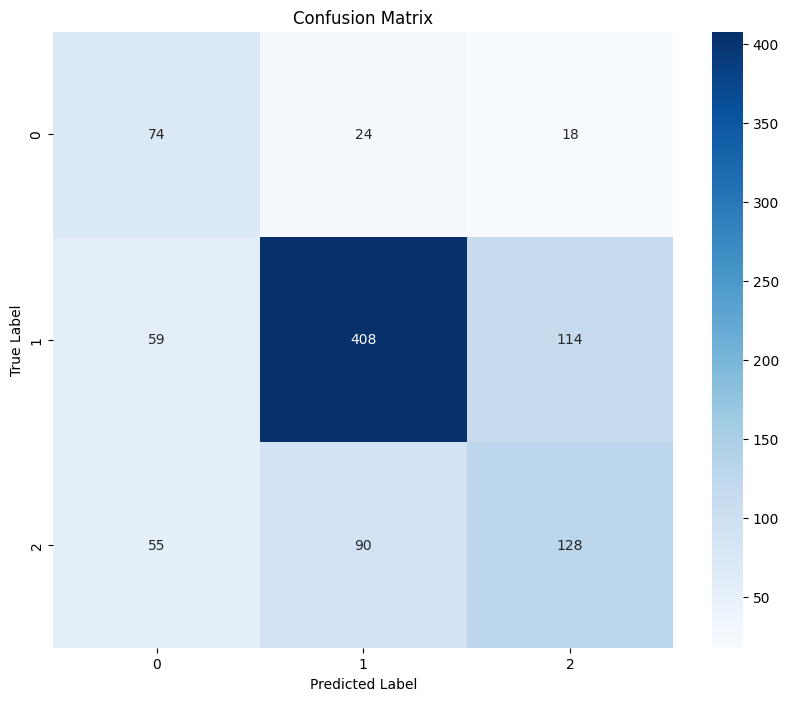


Example Predictions:

Example 1 [✓]
Text: [CLS] operating loss totalled eur 0. 3 mn, down from a profit of eur 5. 1 mn in the first half of 2009. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
True Label: 0
Predicted: Negative (Confidence: 98.30%)

Example 2 [✓]
Text: [CLS] the operating margin of aker yards cruise & ferries division went down from 8. 3 % to 6. 4 % in the first quarter of 2007. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels), np.array(all_probs)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def get_example_predictions(test_data, predictions, probabilities, n=10):
    examples = []
    for i in range(len(predictions)):
        examples.append({
            'text': tokenizer.decode(test_data['input_ids'][i]),
            'true_label': test_data['label'][i].item(),
            'predicted_label': predictions[i],
            'confidence': max(probabilities[i]) * 100
        })

    # Sort by confidence
    examples.sort(key=lambda x: x['confidence'], reverse=True)
    return examples[:n]

# Load the best model
model = LSTMModel(**model_config).to(device)
model.load_state_dict(torch.load('/content/best_model.pt'))
model.to(device)

# Get predictions
predictions, true_labels, probabilities = evaluate_model(model, test_loader, device)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions)

# Print some example predictions
print("\nExample Predictions:")
examples = get_example_predictions(test_data, predictions, probabilities)
for i, example in enumerate(examples, 1):
    sentiment = "Negative" if example['predicted_label'] == 0 else "Neutral" if example['predicted_label'] == 1 else "Positive"
    correct = "✓" if example['predicted_label'] == example['true_label'] else "✗"

    print(f"\nExample {i} [{correct}]")
    print(f"Text: {example['text']}")
    print(f"True Label: {example['true_label']}")
    print(f"Predicted: {sentiment} (Confidence: {example['confidence']:.2f}%)")

# Calculate per-class accuracy
for i in range(3):
    mask = true_labels == i
    class_acc = (predictions[mask] == true_labels[mask]).mean()
    sentiment = "Negative" if i == 0 else "Neutral" if i == 1 else "Positive"
    print(f"\n{sentiment} Class Accuracy: {class_acc:.4f}")

# Calculate overall accuracy
accuracy = (predictions == true_labels).mean()
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Save predictions to DataFrame
results_df = pd.DataFrame({
    'Text': [tokenizer.decode(ids) for ids in test_data['input_ids']],
    'True_Label': true_labels,
    'Predicted_Label': predictions,
    'Confidence': np.max(probabilities, axis=1)
})

# Save to CSV
results_df.to_csv('test_predictions.csv', index=False)

In [ ]:
 def predict_sentiment(model, tokenizer, sentence, device):
    # Set model to evaluation mode
    model.eval()

    # Tokenize the sentence
    inputs = tokenizer(
        sentence,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move inputs to device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        # Get probability scores
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence = torch.max(probabilities).item()

    # Convert prediction to sentiment
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_sentiment = sentiment_map[predicted.item()]

    return predicted_sentiment, confidence

## Test the Model with a Sentence

In [ ]:
sentence = "Earnings are declining 0.5 percent compared to last quarter"

sentiment, confidence = predict_sentiment(model, tokenizer, sentence, device)

print(f"Sentnence: {sentence}\nSentiment: {sentiment}")


Sentnence: Earnings are declining 0.5 percent compared to last quarter
Sentiment: Negative
